Nama : Fitrie Ratnasari \
email: ratnasari.fitrie@gmail.com 

In [1]:
# Import Library yg dibutuhkan

import csv
from urllib.request import urlopen, Request
import requests
from bs4 import BeautifulSoup as bs 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

alamat = "https://pokemondb.net/pokedex/all"
safeAdd = Request(alamat, headers={'User-Agent': 'Mozilla/5.0'})
html = urlopen(safeAdd)
data = bs(html, 'html.parser')

In [2]:
# Menginisiasi table dan stop function yg akan diambil datanya

table = data.find("table", {"id":"pokedex"})
rows = data.findAll("tr")

row_data = []
for row in rows:
    pass

    if row.contents[1].get_text() == "817": #stop function
        break
        
    for item in row.findAll(["th","td"]): #gathering functionpass
        pass

In [3]:
#Mendapatkan data dari fungsi yg telah diinisiasi

row_data = []
for row in rows:
    cell_data = []

    if row.contents[1].get_text() == '817': #stop function
        break


    for item in row.findAll(["th","td"]): #gathering function
        cell_data.append(item.get_text())
    row_data.append(cell_data)

In [4]:
# Menyimpan dataframe ke dalam csv. format
df_ = pd.DataFrame(row_data)
df_.columns = df_.iloc[0]

df_.to_csv('data_pokemon.csv',index=False, header=None)


In [5]:
col =['Name','Attack','Defense']
X_test = pd.read_csv('data_pokemon.csv', usecols=col)
X_test = X_test.iloc[598:816]
X_test

,Name,Attack,Defense
598,Oshawott,55,45
599,Dewott,75,60
600,Samurott,100,85
601,Patrat,55,39
602,Watchog,85,69
...,...,...,...
811,Tyrunt,89,77
812,Tyrantrum,121,119
813,Amaura,59,50
814,Aurorus,77,72


In [6]:
X_test.to_csv('X_test.csv', header=True, index=False)

In [7]:
X_test.drop(columns=['Name'], axis=1, inplace=True)

In [8]:
X_test

,Attack,Defense
598,55,45
599,75,60
600,100,85
601,55,39
602,85,69
...,...,...
811,89,77
812,121,119
813,59,50
814,77,72


In [9]:
X_test.duplicated().sum() #terdapat 24 data duplikat

24

In [10]:
X_test.shape #banyaknya baris sebelum duplikat dihapus

(218, 2)

In [11]:
X_test.drop_duplicates(keep='first', inplace=True) #menghapus data duplikat

In [12]:
X_test.shape #banyaknya data setelah duplikat dihapus

(194, 2)

In [13]:
X_test.duplicated().sum() #test apakah masih ada duplikat

0

In [14]:
X_test.head()

,Attack,Defense
598,55,45
599,75,60
600,100,85
601,55,39
602,85,69


## Mendefinisikan X Train dan Label untuk data 1-500


In [42]:
# Mengambil data klastering sebelumnya yang sudah disimpan dalam csv sebagai data training
X_Train = pd.read_csv('pokemon_XTrain.csv')
X_Train.head()

,Attack,Defense,Log-Attack,Log-Defense,kluster
0,49,49,3.912023,3.912023,1
1,62,63,4.143135,4.158883,1
2,82,83,4.418841,4.430817,0
3,100,123,4.615121,4.820282,0
4,52,43,3.970292,3.784190,1


In [50]:
X_Train['kluster'].value_counts()

0    317
1    158
Name: kluster, dtype: int64

In [59]:
kluster_train_count = X_Train['kluster'].value_counts().to_frame()
kluster_train_count

,kluster
0,317
1,158


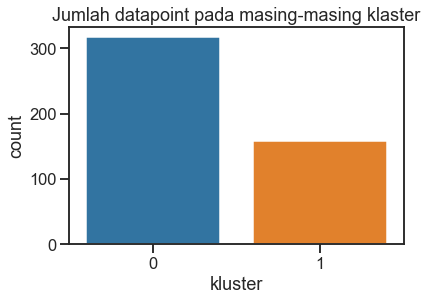

In [60]:
sns.countplot('kluster',data = X_Train)
plt.title('Jumlah datapoint pada masing-masing klaster')
plt.show()

In [16]:
set_data = X_Train.iloc[:, 2:4]
kluster_data = X_Train.iloc[:,-1]
#kluster_data.head()

##  Mencari Nilai K KNN Maksimum untuk data 1-500 

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [18]:
x_train, x_test, y_train, y_test = train_test_split(set_data, kluster_data, test_size=0.25,random_state=150)

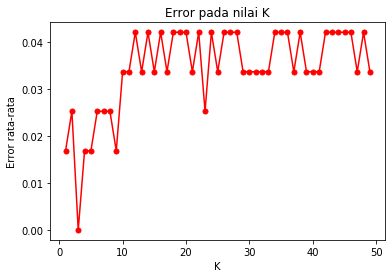

In [19]:
#Menggunakan data error pada setiap nilai K

error = []
for i in range(1, 50):
    model_k = KNeighborsClassifier(n_neighbors=i)
    model_k.fit(x_train, y_train)
    y_pred = model_k.predict(x_test)
    error.append(np.mean(y_pred != y_test))

plt.figure(1)  
plt.plot(range(1, 50), error, color='red', marker='o', markersize=5)
plt.title('Error pada nilai K')  
plt.xlabel('K')  
plt.ylabel('Error rata-rata')
plt.show()

In [20]:
error[2]

0.0

In [21]:
# Mencari nilai K KNN berdasarkan F1-Score 

max_k = 50
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(x_train, y_train)
    
    y_pred = knn.predict(x_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1800x1200 with 0 Axes>

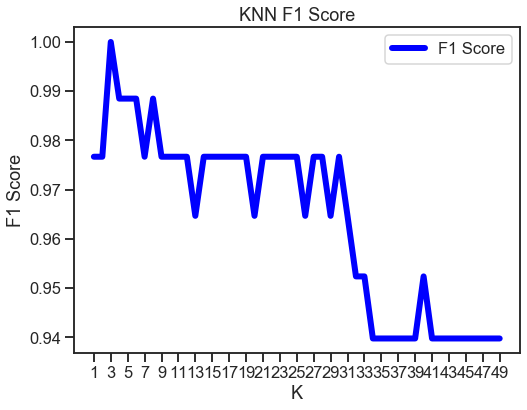

In [66]:
# Plot F1 results
import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(color='blue', figsize=(8, 6), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

In [23]:
error_rates[2]

(3, 0.0)

In [24]:
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

**Baik menggunakan F1-Score maupun error-score, didapatkan nilai k-optimum untuk KNN K=3, dengan error 0. Artinya model dapat mengklasifikasikan data point secara sempurna, tidak ada prediksi yang salah dalam klasifikasi.**

In [53]:
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        44

    accuracy                           1.00       119
   macro avg       1.00      1.00      1.00       119
weighted avg       1.00      1.00      1.00       119

Accuracy score:  1.0
F1 Score:  1.0


**Sejalan dengan grafik di atas, jika kita melakukan plot confusion matrix dari model klasifikasi yang kita pilih juga menghasilkan output serupa yaitu akurasi 100% dan F1 Score 1.0 yang artinya sempurna**

## Normalisasi X_test menggunakan Logaritmik

In [30]:
X_test['Log-Attack'] = np.log1p(X_test['Attack'])
X_test['Log-Defense'] = np.log1p(X_test['Defense'])
X_test

,Attack,Defense,Log-Attack,Log-Defense
598,55,45,4.025352,3.828641
599,75,60,4.330733,4.110874
600,100,85,4.615121,4.454347
601,55,39,4.025352,3.688879
602,85,69,4.454347,4.248495
...,...,...,...,...
810,55,52,4.025352,3.970292
811,89,77,4.499810,4.356709
812,121,119,4.804021,4.787492
813,59,50,4.094345,3.931826


## Melakukan Prediksi dari Klasifikasi KNN untuk data 501-700

In [31]:
yhat = neigh.predict(X_test.iloc[:,2:4]) #data yang dimasukkan ke dalam ML hanya data yg sudah ditransformasi log saja
yhat

array([1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0])

In [32]:
#Ubah array prediksi dalam bentuk dataframe
import numpy as np
import pandas as pd

df = pd.DataFrame(yhat, columns = ['kluster'])

print(df)
print(type(df))

     kluster
0          1
1          0
2          0
3          1
4          0
..       ...
189        1
190        0
191        0
192        1
193        0

[194 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


In [38]:
X_test['kluster']=df.values

In [39]:
X_test

,Attack,Defense,Log-Attack,Log-Defense,kluster
598,55,45,4.025352,3.828641,1
599,75,60,4.330733,4.110874,0
600,100,85,4.615121,4.454347,0
601,55,39,4.025352,3.688879,1
602,85,69,4.454347,4.248495,0
...,...,...,...,...,...
810,55,52,4.025352,3.970292,1
811,89,77,4.499810,4.356709,0
812,121,119,4.804021,4.787492,0
813,59,50,4.094345,3.931826,1


In [61]:
kluster_tes_count = X_test['kluster'].value_counts().to_frame()
kluster_tes_count

,kluster
0,127
1,67


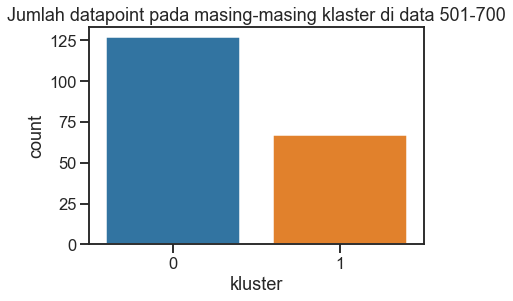

In [62]:
sns.countplot('kluster',data = X_test)
plt.title('Jumlah datapoint pada masing-masing klaster di data 501-700')
plt.show()

In [40]:
x_baru=X_test.copy() #Data baru yang sudah diberi label

In [43]:
# Melakukan merge dataframe antara data 0-500 dengan data baru yang sudah dilabeli
x_all = pd.concat([X_Train, x_baru], axis=0)
x_all

,Attack,Defense,Log-Attack,Log-Defense,kluster
0,49,49,3.912023,3.912023,1
1,62,63,4.143135,4.158883,1
2,82,83,4.418841,4.430817,0
3,100,123,4.615121,4.820282,0
4,52,43,3.970292,3.784190,1
...,...,...,...,...,...
810,55,52,4.025352,3.970292,1
811,89,77,4.499810,4.356709,0
812,121,119,4.804021,4.787492,0
813,59,50,4.094345,3.931826,1


In [63]:
klaster_all = x_all['kluster'].value_counts().to_frame()
klaster_all

,kluster
0,444
1,225


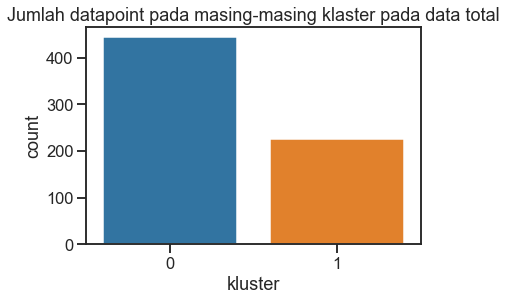

In [67]:
sns.countplot('kluster',data = x_all)
plt.title('Jumlah datapoint pada masing-masing klaster pada data total')
plt.show()

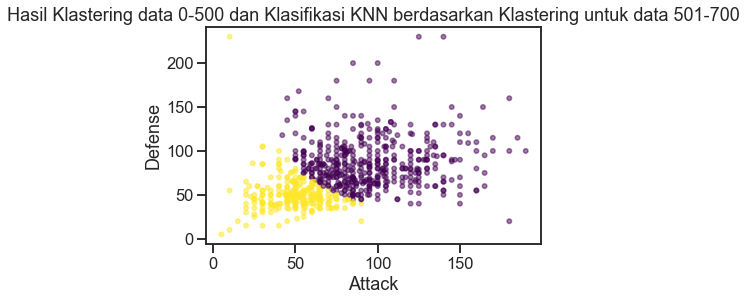

In [54]:
c = ['red','blue']
plt.scatter(x_all.Attack, x_all.Defense, s = 20, c = x_all.kluster, marker = "o", alpha = 0.5, cmap='viridis')
plt.title("Hasil Klastering data 0-500 dan Klasifikasi KNN berdasarkan Klastering untuk data 501-700")
plt.xlabel("Attack")
plt.ylabel("Defense")
plt.show()